In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
# define the feature names:
feat_names=['age','bp','sg','al','su','rbc','pc',
'pcc','ba','bgr','bu','sc','sod','pot','hemo',
'pcv','wbcc','rbcc','htn','dm','cad','appet','pe',
'ane','classk']
feat_cat=np.array(['num','num','cat','cat','cat','cat','cat','cat','cat',
         'num','num','num','num','num','num','num','num','num',
         'cat','cat','cat','cat','cat','cat','cat'])

In [3]:
#import the dataframe:

#xx=pd.read_csv("./Chronic_Kidney_Disease/chronic_kidney_disease.arff",sep=',',
 #              skiprows=29,names=feat_names,
  #             header=None,na_values=['?','\t?'],
   #            warn_bad_lines=True)
xx=pd.read_csv("./chronic_kidney_disease_v2.arff",sep=',',
    skiprows=29,names=feat_names,
    header=None,na_values=['?','\t?'],)

FileNotFoundError: [Errno 2] No such file or directory: './chronic_kidney_disease_v2.arff'

In [ ]:
Np,Nf=xx.shape

In [ ]:
target_names = ['notckd','ckd']# for the final plots
mapping={
    'normal':0,
    'abnormal':1,
    'present':1,
    'notpresent':0,
    'yes':1,
    ' yes':1,
    'no':0,
    '\tno':0,
    '\tyes':1,
    'ckd':1,
    'notckd':0,
    'poor':1,
    'good':0,
    'ckd\t':1}
xx=xx.replace(mapping.keys(),mapping.values())


In [ ]:
print('cardinality of each feature:')
print(xx.nunique())# show the cardinality of each feature in the dataset; in particular classk should have only two possible values

cardinality of each feature:
age        76
bp         10
sg          5
al          6
su          6
rbc         2
pc          2
pcc         2
ba          2
bgr       146
bu        118
sc         84
sod        34
pot        40
hemo      115
pcv        42
wbcc       89
rbcc       45
htn         2
dm          2
cad         2
appet       2
pe          2
ane         2
classk      2
dtype: int64


In [ ]:
miss_values = xx.isnull().sum(axis=1)
for k in range(miss_values.max()+1):
    print(k,np.sum(miss_values==k))

0 158
1 45
2 33
3 37
4 31
5 33
6 12
7 20
8 8
9 12
10 4
11 7


In [ ]:
print(xx.info())
x=xx.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    float64
 6   pc      335 non-null    float64
 7   pcc     396 non-null    float64
 8   ba      396 non-null    float64
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    float64
 19  dm      398 non-null    float64
 20  cad     398 non-null    float64
 21  appet   399 non-null    float64
 22  pe

In [ ]:
# drop rows with less than 19=Nf-6 recorded features:
x=x.dropna(thresh=19)
x.reset_index(drop=True, inplace=True)# necessary to have index without "jumps"
n=x.isnull().sum(axis=1)# check the number of missing values in each row
print('Number of points in the original dataset: ',xx.shape[0])
print('reduced dataset: at least 19 values per row')
print('number of points in the reduced dataset: ',x.shape[0])
print('max number of missing values in the reduced dataset: ',n.max())

Number of points in the original dataset:  400
reduced dataset: at least 19 values per row
number of points in the reduced dataset:  349
max number of missing values in the reduced dataset:  6


In [ ]:
# take the rows with exctly Nf=25 useful features; this is going to be the training dataset
# for regression
Xtrain=x.dropna(thresh=25)
Xtrain.reset_index(drop=True, inplace=True)# reset the index of the dataframe
print('Number of points in the training dataset: ',Xtrain.shape[0])

Number of points in the training dataset:  158


In [ ]:
mm=Xtrain.mean(axis=0)
ss=Xtrain.std(axis=0)
Xtrain_norm=(Xtrain-mm)/ss
#%% normalize the entire dataset using the coeffs found for the training dataset
X_norm=(x-mm)/ss
Np,Nf=X_norm.shape

In [ ]:
#%% run linear regression using least squares on all the missing data
for kk in range(Np):
    xrow=X_norm.iloc[kk]#k-th row
    mask=xrow.isna()# columns with nan in row k
    Data_tr_norm=Xtrain_norm.loc[:,~mask]# remove the columns from the training dataset
    y_tr_norm=Xtrain_norm.loc[:,mask]# columns to be regressed
    w1=np.linalg.inv(np.dot(Data_tr_norm.T,Data_tr_norm))
    w=np.dot(np.dot(w1,Data_tr_norm.T),y_tr_norm)# weight vector
    ytest_norm=np.dot(X_norm.loc[kk,~mask],w)
    X_norm.iloc[kk][mask]=ytest_norm # substitute nan with regressed values
x_new=X_norm*ss+mm # denormalize

In [ ]:
#%% manage categorical features
# get the possible values (i.e. alphabet) for the categorical features
alphabets=[]
for k in range(len(feat_cat)):
    if feat_cat[k]=='cat':
        val=Xtrain[Xtrain.columns[k]].unique()
        alphabets.append(np.sort(val))
    else:
        alphabets.append('num')
index=np.argwhere(feat_cat=='cat').flatten()
for k in index:
    val=alphabets[k].flatten()
    c=x_new[x_new.columns[k]].values
    val = val.reshape(1,-1) # force row vector
    c=c.reshape(-1,1) # force column vector
    d=(val-c)**2 # find the square distances
    ii=d.argmin(axis=1) # find the closest categorical value
    cc=val[0,ii] # cc contains only the categorical values
    x_new[x_new.columns[k]]=cc
print(x_new.nunique())
print(x_new.describe().T)

age        79
bp         17
sg          5
al          5
su          6
rbc         2
pc          2
pcc         2
ba          2
bgr       164
bu        116
sc         82
sod        90
pot        97
hemo      137
pcv        74
wbcc      150
rbcc      129
htn         2
dm          2
cad         2
appet       2
pe          2
ane         2
classk      2
dtype: int64
        count         mean          std          min          25%  \
age     349.0    50.812526    16.816782     3.000000    41.000000   
bp      349.0    75.974609    13.637450    50.000000    70.000000   
sg      349.0     1.017636     0.005667     1.005000     1.015000   
al      349.0     1.031519     1.348321     0.000000     0.000000   
su      349.0     0.444126     1.085644     0.000000     0.000000   
rbc     349.0     0.283668     0.451425     0.000000     0.000000   
pc      349.0     0.243553     0.429842     0.000000     0.000000   
pcc     349.0     0.114613     0.319012     0.000000     0.000000   
ba      349.0   

In [ ]:
#%% check the distributions
L=x_new.shape[0]
plotCDF=False # change to True if you want the plots
if plotCDF:
    for k in range(Nf):
        plt.figure()
        a=xx[xx.columns[k]].dropna()
        M=a.shape[0]
        plt.plot(np.sort(a),np.arange(M)/M,label='original dataset')
        plt.plot(np.sort(x_new[x_new.columns[k]]),np.arange(L)/L,label='regressed dataset')
        plt.title('CDF of '+xx.columns[k])
        plt.xlabel('x')
        plt.ylabel('P(X<=x)')
        plt.grid()
        plt.legend(loc='upper left')

In [ ]:
#%%------------------ Decision trees -------------------
# Let us use only the complete data (no missing values)
target = Xtrain.classk
inform = Xtrain.drop('classk', axis=1)
clfXtrain = tree.DecisionTreeClassifier(criterion='entropy',random_state=4)
clfXtrain = clfXtrain.fit(inform,target)
test_pred = clfXtrain.predict(x_new.drop('classk', axis=1))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Performance of the decision tree based on the training dataset only:')
print('accuracy =', accuracy_score(x_new.classk,test_pred))
print(confusion_matrix(x_new.classk,test_pred))

Performance of the decision tree based on the training dataset only:
accuracy = 0.9283667621776505
[[150   0]
 [ 25 174]]


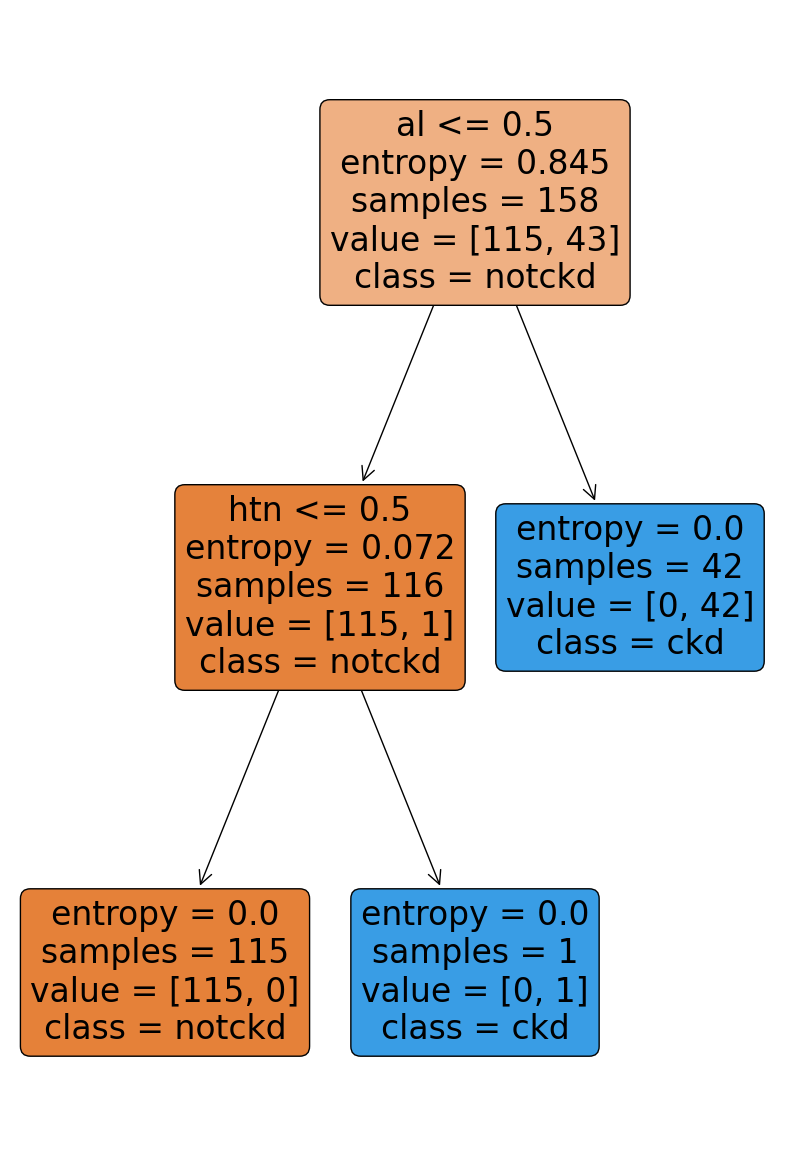

In [ ]:
plt.figure(figsize=(10,15))
tree.plot_tree(clfXtrain,feature_names=feat_names[:24],
               class_names=target_names,rounded=True,
               proportion =False ,filled = True )
plt.savefig('fig_training.png' )

In [ ]:
median_values = Xtrain.median()

#Substitute missing values in x with the median values
y_new = x.copy()  # Create a copy of x to store the new dataset

for column in x.columns:
    # For numeric columns, replace missing values with the median of the respective feature
    if x[column].dtype != 'object':
        median_val = median_values[column]
        y_new[column].fillna(median_val, inplace=True)

# Ensure y_new has the same number of rows (400 rows)
y_new = y_new.head(400)

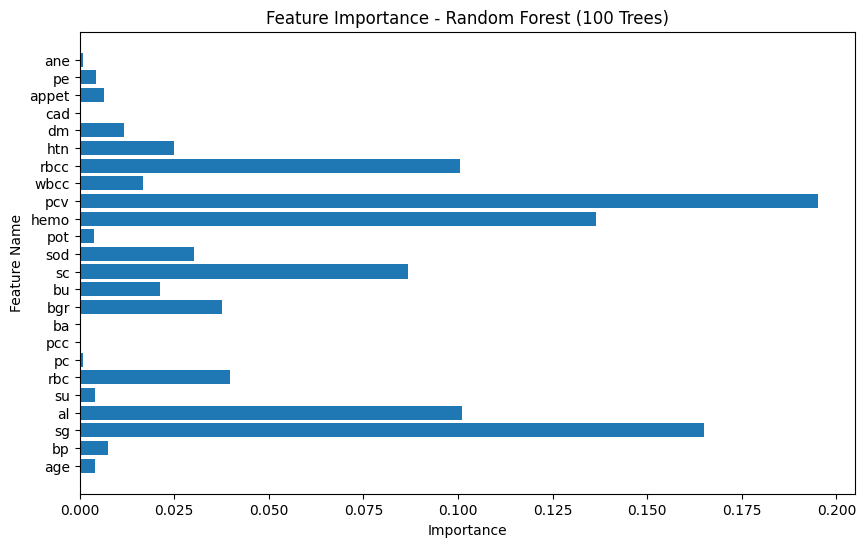

0.994269340974212


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with 100 trees
rf_100 = RandomForestClassifier(n_estimators=100)

# Train the model on x_new and y_new
rf_100.fit(x_new.drop('classk', axis=1), x_new['classk'])

# Predict using the trained model
predictions_100 = rf_100.predict(y_new.drop('classk', axis=1))

# Get accuracy and confusion matrix for 100 trees
accuracy_100 = accuracy_score(y_new['classk'], predictions_100)
confusion_matrix_100 = confusion_matrix(y_new['classk'], predictions_100)

# Feature Importance for 100 trees
importances_100 = rf_100.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(x_new.columns[:-1], importances_100)
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - Random Forest (100 Trees)')
plt.show()
print(accuracy_100)

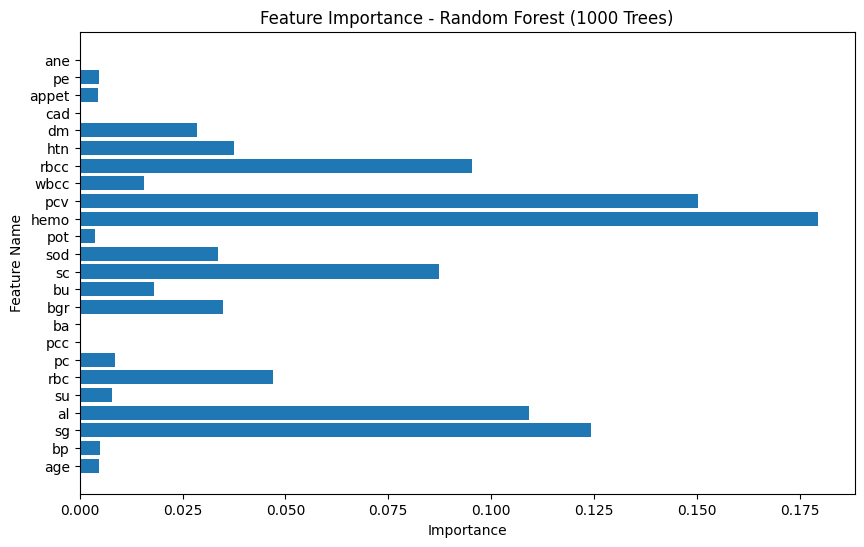

0.994269340974212


In [ ]:
# Create a Random Forest classifier with 1000 trees
rf_1000 = RandomForestClassifier(n_estimators=1000)

# Train the model on x_new and y_new
rf_1000.fit(x_new.drop('classk', axis=1), x_new['classk'])

# Predict using the trained model
predictions_1000 = rf_1000.predict(y_new.drop('classk', axis=1))

# Get accuracy and confusion matrix for 1000 trees
accuracy_1000 = accuracy_score(y_new['classk'], predictions_1000)
confusion_matrix_1000 = confusion_matrix(y_new['classk'], predictions_1000)

# Feature Importance for 1000 trees
importances_1000 = rf_1000.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(x_new.columns[:-1], importances_1000)
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance - Random Forest (1000 Trees)')
plt.show()
print(accuracy_1000)

In [ ]:
from sklearn.model_selection import train_test_split

# Split y_new into training and test subsets (50%)
y_train, y_test = train_test_split(y_new, test_size=0.5, shuffle=True)

# Random Forest Classifier with 1000 trees on the training dataset
rf_1000 = RandomForestClassifier(n_estimators=1000)
rf_1000.fit(y_train.drop('classk', axis=1), y_train['classk'])
predictions_rf_1000 = rf_1000.predict(y_test.drop('classk', axis=1))

# Accuracy and Confusion Matrix for Random Forest (1000 trees) on test dataset
accuracy_rf_1000 = accuracy_score(y_test['classk'], predictions_rf_1000)
confusion_matrix_rf_1000 = confusion_matrix(y_test['classk'], predictions_rf_1000)

# CART Decision Tree Classifier on the training dataset
clf_cart = tree.DecisionTreeClassifier(criterion='entropy')
clf_cart.fit(y_train.drop('classk', axis=1), y_train['classk'])
predictions_cart = clf_cart.predict(y_test.drop('classk', axis=1))

# Accuracy and Confusion Matrix for CART Decision Tree on test dataset
accuracy_cart = accuracy_score(y_test['classk'], predictions_cart)
confusion_matrix_cart = confusion_matrix(y_test['classk'], predictions_cart)

In [ ]:
print(accuracy_cart)
print(confusion_matrix_cart)

0.9885714285714285
[[76  0]
 [ 2 97]]
